In [1]:
library("DescTools")
library("Biostrings")
library("seqinr")
library("stringr")
library("FNN")
library("ape")
library("RCurl")
library("diagram")
library("ggplot2")
library("corrplot")
library("qgraph")
library("visNetwork")
library("Rgraphviz")
library("bnlearn")
library("plotrix")
library("bio3d")
library("ggpubr")
library("ouch")
library("ggrepel")
library("devtools")
library("fitdistrplus")
library("MASS")
library("mixtools")
library("subplex")
packageurl <- "https://cran.r-project.org/src/contrib/Archive/ouch/ouch_2.11-1.tar.gz"
install.packages(packageurl, repos=NULL, type="source")
library("ouch")
library("circlize")

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which.min

Loading required package: S4Vectors
Loading required package: s

In [2]:
aln <- bio3d::read.fasta("./PLD.translated.fasta")
PTM=c(2,3,7,11,19,26,30,37,42,54,57,61,68,71,77,78, 84, 86, 87, 95, 96, 108, 109, 110, 112, 115, 117, 127, 129, 131, 135, 142, 148)
iTOL_output=matrix(0, nrow = 87, ncol = length(PTM))

Phospho_score=rep(0, 87)

for (i in 1:87){
    
    for (j in 1:length(PTM)){
        
        if ( (aln$ali[i, PTM[j]]=="S") | (aln$ali[i, PTM[j]]=="T")) {
           
            iTOL_output[i,j]=1
            }                
    }
}

In [10]:
Phospho_potential=rowSums(iTOL_output)
names(Phospho_potential)=aln$id

FUS_tree=read.tree("./PLD_89_BLengths.nwk")
FUS_ouch_tree=ape2ouch(FUS_tree, scale = TRUE, branch.lengths = FUS_tree$edge.length*10)


In [11]:
### Use the right conversions for the data input
index=match(FUS_ouch_tree@nodelabels, aln$id)
index=index[which(!is.na(index))]
Phospho_score_rev=Phospho_potential[index]
#Phospho_score_rev=sample(Phospho_score_rev)  ## Randomize

In [12]:
Data=list()
Data[[1]]=c(rep(NA,85), Phospho_score_rev)  # This Data vector has some ancestral values as well as extant sequences
Data=as.data.frame(Data)
colnames(Data)="Random"
print( h1 <- brown(Data['Random'],FUS_ouch_tree))

regimes=list()
regimes=rep("ns", length(Data[,1]))
regimes=as.data.frame(regimes)
# Compare it with two models

print(h2 <- hansen(Data,FUS_ouch_tree,regimes,sqrt.alpha=1,sigma=1))


call:
brown(data = Data["Random"], tree = FUS_ouch_tree)
    nodes ancestors        times                     labels Random
1       1      <NA> 0.000000e+00                                NA
2       2         3 2.841648e-02                                NA
3       3         4 4.319730e-07                                NA
4       4         1 2.159865e-07                                NA
5       5         7 1.102629e-01                                NA
6       6         7 1.102629e-01                                NA
7       7        10 1.102626e-01                                NA
8       8         9 1.102886e-01                                NA
9       9        10 1.102884e-01                                NA
10     10        11 1.102624e-01                                NA
11     11        15 1.101465e-01                                NA
12     12        14 1.078154e-01                                NA
13     13        14 1.101700e-01                                NA
14  


call:
hansen(data = Data, tree = FUS_ouch_tree, regimes = regimes, 
    sqrt.alpha = 1, sigma = 1)
    nodes ancestors        times                     labels regimes Random
1       1      <NA> 0.000000e+00                                 ns     NA
2       2         3 2.841648e-02                                 ns     NA
3       3         4 4.319730e-07                                 ns     NA
4       4         1 2.159865e-07                                 ns     NA
5       5         7 1.102629e-01                                 ns     NA
6       6         7 1.102629e-01                                 ns     NA
7       7        10 1.102626e-01                                 ns     NA
8       8         9 1.102886e-01                                 ns     NA
9       9        10 1.102884e-01                                 ns     NA
10     10        11 1.102624e-01                                 ns     NA
11     11        15 1.101465e-01                                 ns     NA


In [14]:
get_vector <- function (h, simul.time){
    
    # h is the Uhlenbeck model
    # simul time: number of simulations
    
    SIM=simulate(h, nsim = simul.time)
    index=which(SIM[[1]][,1] != "<NA>")
    vector_old=SIM[[1]][index,1]
    
    for (i in 2:simul.time){
     
    vector_new=SIM[[i]][index,1]
        
    vector_old=c(vector_old, vector_new)
        
    }
    
    return(vector_old)
}


	Two-sample Kolmogorov-Smirnov test

data:  BROWN and HANSEN
D = 0.10149, p-value < 2.2e-16
alternative hypothesis: two-sided


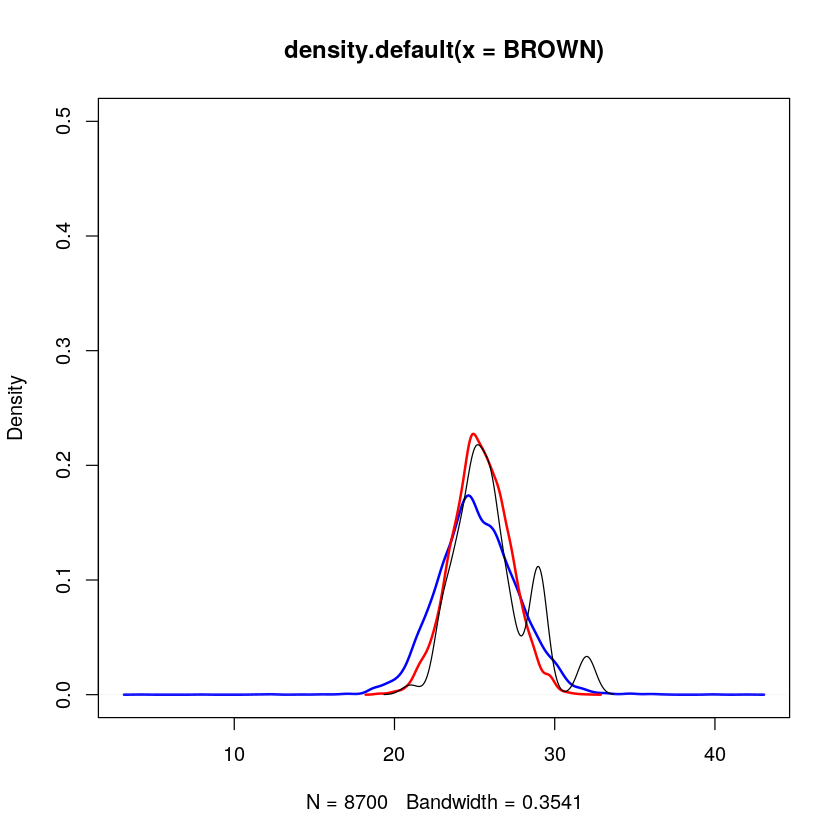

In [15]:
BROWN=get_vector(h = h1, simul.time = 100)
HANSEN=get_vector(h = h2, simul.time = 100)
plot(density(BROWN), ylim=c(0, 0.5), col="blue", lwd=2)
lines(density(HANSEN), col="red", lwd=2)
lines(density(Phospho_score_rev, na.rm = TRUE))
ks.test(BROWN, HANSEN)


## Uhlenbeck on phosphosites without primates

In [16]:
aln <- bio3d::read.fasta("./PLD.translated.fasta")
PTM=c(2,3,7,11,19,26,30,37,42,54,57,61,68,71,77,78, 84, 86, 87, 95, 96, 108, 109, 110, 112, 115, 117, 127, 129, 131, 135, 142, 148)
iTOL_output=matrix(0, nrow = 87, ncol = length(PTM))

Phospho_score=rep(0, 87)

for (i in 1:87){
    
    for (j in 1:length(PTM)){
        
        if ( (aln$ali[i, PTM[j]]=="S") | (aln$ali[i, PTM[j]]=="T")) {          
            iTOL_output[i,j]=1
            }                
    }
}

In [17]:
Phospho_potential=rowSums(iTOL_output)
names(Phospho_potential)=aln$id

In [18]:
FUS_tree=read.tree("./BGM_PLD/PLD_89_BLengths.nwk")

In [19]:
limit=26
FUS_tree_trimmed=drop.tip(phy = FUS_tree, names(which(Phospho_potential > limit)))
FUS_ouch_tree=ape2ouch(FUS_tree_trimmed, scale = TRUE, branch.lengths = FUS_tree_trimmed$edge.length)

Phospho_potential_trimmed=Phospho_potential[-which(Phospho_potential > limit)]

### Use the right conversions for the data input
index=match(FUS_ouch_tree@nodelabels, names(Phospho_potential_trimmed))
Phospho_score_rev=Phospho_potential_trimmed[index]
#Phospho_score_rev=sample(Phospho_score_rev)  ## Randomize
Phospho_score_rev

<NA>                       <NA> 
                        NA                         NA 
                      <NA>                       <NA> 
                        NA                         NA 
                      <NA>                       <NA> 
                        NA                         NA 
                      <NA>                       <NA> 
                        NA                         NA 
                      <NA>                       <NA> 
                        NA                         NA 
                      <NA>                       <NA> 
                        NA                         NA 
                      <NA>                       <NA> 
                        NA                         NA 
                      <NA>                       <NA> 
                        NA                         NA 
                      <NA>                       <NA> 
                        NA                         NA 
                      <NA>                       <NA> 
                        NA                         NA 
                      <NA>                       <NA> 
                        NA                         NA 
                      <NA>                       <NA> 
                        NA                         NA 
                      <NA>                       <NA> 
                        NA                         NA 
                      <NA>                       <NA> 
                        NA                         NA 
                      <NA>                       <NA> 
                        NA                         NA 
                      <NA>                       <NA> 
                        NA                         NA 
                      <NA>                       <NA> 
                        NA                         NA 
                      <NA>                       <NA> 
                        NA                         NA 
                      <NA>                       <NA> 
                        NA                         NA 
                      <NA>                       <NA> 
                        NA                         NA 
                      <NA>                       <NA> 
                        NA                         NA 
                      <NA>                       <NA> 
                        NA                         NA 
                      <NA>                       <NA> 
                        NA                         NA 
                      <NA>                       <NA> 
                        NA                         NA 
                      <NA>                       <NA> 
                        NA                         NA 
                      <NA>                       <NA> 
                        NA                         NA 
                      <NA>                       <NA> 
                        NA                         NA 
                      <NA>                       <NA> 
                        NA                         NA 
                      <NA>              Gallus_gallus 
                        NA                         26 
     Elephantulus_edwardii     Chrysochloris_asiatica 
                        24                         25 
      Dasypus_novemcinctus      Oryctolagus_cuniculus 
                        24                         23 
             Octodon_degus            Cavia_porcellus 
                        24                         25 
     Heterocephalus_glaber            Marmota_marmota 
                        24                         25 
      Marmota_flaviventris        Urocitellus_parryii 
                        25                         25 
           Dipodomys_ordii         Nannospalax_galili 
                        25                         26 
        Cricetulus_griseus       Mesocricetus_auratus 
                        25                         25 
    Peromyscus_maniculatus      Meriones_unguiculatus 
       

In [20]:
Data=list()
Data[[1]]=Phospho_score_rev  # This Data vector has some ancestral values as well as extant sequences
Data=as.data.frame(Data)
colnames(Data)="Random"
print( h1 <- brown(Data['Random'],FUS_ouch_tree))

regimes=list()
regimes=rep("ns", length(Data[,1]))
regimes=as.data.frame(regimes)
# Compare it with two models

print(h2 <- hansen(Data,FUS_ouch_tree,regimes,sqrt.alpha=1,sigma=1))


call:
brown(data = Data["Random"], tree = FUS_ouch_tree)
    nodes ancestors        times                     labels Random
1       1      <NA> 0.000000e+00                                NA
2       2         3 2.841648e-02                                NA
3       3         1 2.159865e-07                                NA
4       4         5 5.707921e-02                                NA
5       5        16 2.483564e-02                                NA
6       6         7 1.102891e-01                                NA
7       7        15 1.102889e-01                                NA
8       8         9 7.455893e-02                                NA
9       9        12 7.455871e-02                                NA
10     10        11 7.455893e-02                                NA
11     11        12 7.455871e-02                                NA
12     12        13 7.455850e-02                                NA
13     13        14 7.455828e-02                                NA
14  


	Two-sample Kolmogorov-Smirnov test

data:  BROWN and HANSEN
D = 0.18627, p-value < 2.2e-16
alternative hypothesis: two-sided


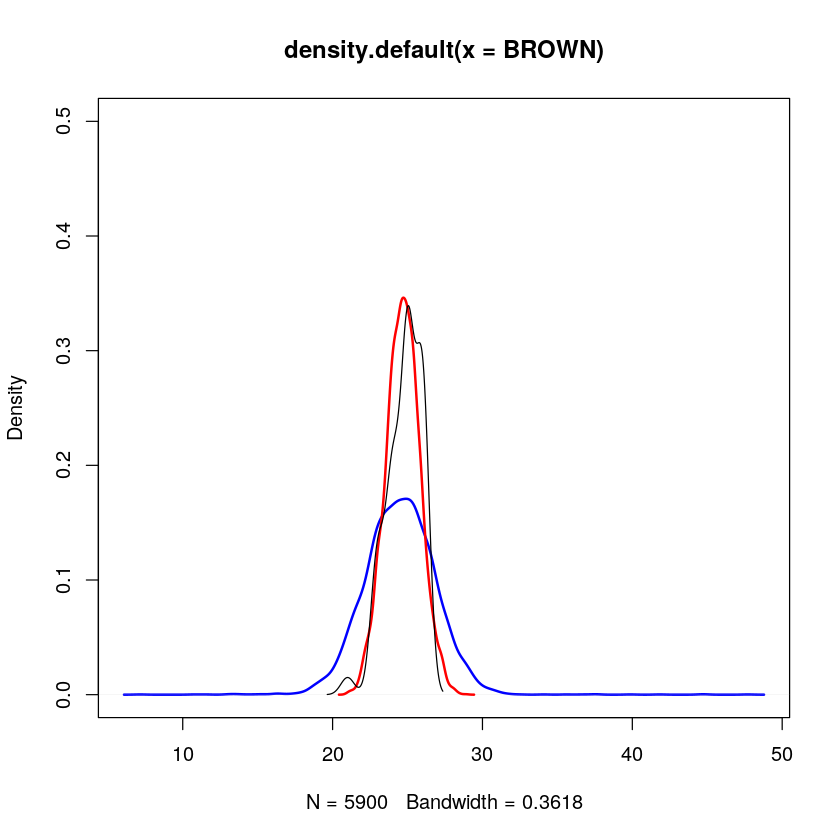

In [21]:

BROWN=get_vector(h = h1, simul.time = 100)
HANSEN=get_vector(h = h2, simul.time = 100)
plot(density(BROWN), ylim=c(0, 0.5), col="blue", lwd=2)
lines(density(HANSEN), col="red", lwd=2)
lines(density(Phospho_score_rev, na.rm = TRUE))
ks.test(BROWN, HANSEN)


### Two-Optima model (OU2)

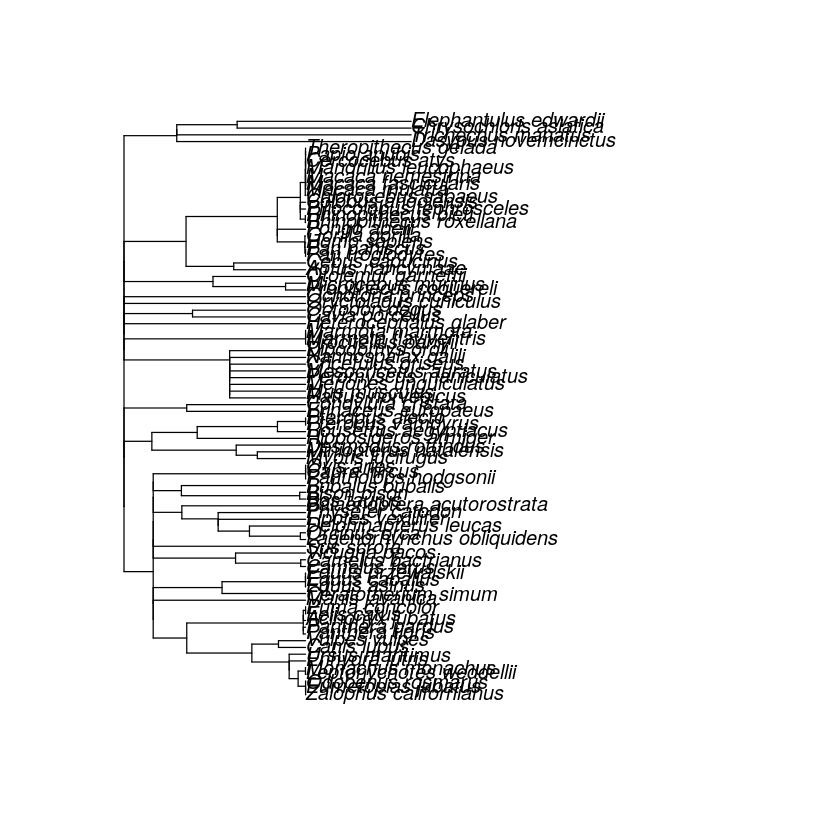

In [22]:
#FUS_tree=read.tree("FUS_TimeTree.nwk")
FUS_tree=read.tree("./BGM_PLD/PLD_89_BLengths.nwk")

index_remove=which(FUS_tree$tip.label=="Gallus_gallus")
FUS_tree=drop.tip(FUS_tree, index_remove)

FUS_tree=unroot(FUS_tree)
plot.phylo(FUS_tree)

In [23]:
index_remove=which(is.na(match(FUS_tree$tip.label, names(Phospho_potential))))
FUS_tree=drop.tip(FUS_tree, index_remove)


In [24]:
FUS_tree=read.tree("./BGM_PLD/PLD_89_BLengths.nwk")
FUS_ouch_tree=ape2ouch(FUS_tree, scale = TRUE, branch.lengths = FUS_tree$edge.length)
FUS_ouch_tree

    nodes ancestors        times                     labels
1       1      <NA> 0.000000e+00                           
2       2         3 2.841648e-02                           
3       3         4 4.319730e-07                           
4       4         1 2.159865e-07                           
5       5         7 1.102629e-01                           
6       6         7 1.102629e-01                           
7       7        10 1.102626e-01                           
8       8         9 1.102886e-01                           
9       9        10 1.102884e-01                           
10     10        11 1.102624e-01                           
11     11        15 1.101465e-01                           
12     12        14 1.078154e-01                           
13     13        14 1.101700e-01                           
14     14        15 1.078152e-01                           
15     15        20 1.078150e-01                           
16     16        17 1.102734e-01        

In [ ]:
### Use the right conversions for the data input
index=match(FUS_ouch_tree@nodelabels, names(Phospho_potential))
Phospho_score_rev=Phospho_potential[index]